In [1]:
import sys
import os

parent_path = ".."
sys.path.append(os.path.abspath(parent_path))

In [2]:
import nltk
import pandas as pd
import numpy as np
from health_causenet import constants
from tqdm.autonotebook import tqdm
import pathlib
import operator
import os
import json
from urllib.parse import urlparse
import matplotlib.pyplot as plt

tqdm.pandas()

tokenizer = nltk.tokenize.TreebankWordTokenizer()

/tmp/ipykernel_3668447/3479549462.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
remove_pubmed = False
full_causenet = pd.DataFrame()
paths = sorted(pathlib.Path(constants.CAUSENET_PARQUET_PATH).glob("causenet_*.parquet"))
for path in tqdm(paths):
    from_file = pd.read_parquet(path, columns=["cause", "effect", "support", "reference", "sentence"])
    if remove_pubmed:
        pubmed = from_file.reference.str.startswith("http://www.ncbi.nlm.nih.gov/pubmed/")
        from_file = from_file.loc[~pubmed]
    full_causenet = full_causenet.append(from_file)
full_causenet = full_causenet.reset_index(drop=True)
# print("parsing domain...")
# full_causenet["domain"] = full_causenet.reference.map(lambda x: urlparse(x).netloc)
# print("computing counts...")
# causenet = full_causenet.groupby(["cause", "effect", "support"]).size()
# causenet.name = "count"
# causenet = causenet.reset_index()
# causenet

  0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_3668447/3895029036.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_causenet = full_causenet.append(from_file)
/tmp/ipykernel_3668447/3895029036.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_causenet = full_causenet.append(from_file)
/tmp/ipykernel_3668447/3895029036.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_causenet = full_causenet.append(from_file)
/tmp/ipykernel_3668447/3895029036.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_causenet = full_causenet.append(from_file)
/tmp/ipykernel_3668447/3895029036.py:9: FutureWarning: The frame.append method is deprecated and will be rem

In [2]:
cf = pd.read_parquet(os.path.join(constants.CF_PATH, "cf.parquet"))
cf.loc[cf.num_terms == 1].sum().astype(str)
cf

corpus_frequency_open_domain       2956489149.0
corpus_frequency_pubmed            3780908995.0
corpus_frequency_pubmed_central    5395154471.0
corpus_frequency_textbook            13915204.0
corpus_frequency_encyclopedia         9325699.0
num_terms                            25315236.0
dtype: object

# Manual evaluation of CauseNet

### Low vs High Support (== 1 vs >= 1)
* first glance precision of low support is quite good, high support very good

In [13]:
causenet.shape[0], (causenet.support == 1).sum(), (causenet.support > 1).sum()

(11592919, 11412759, 180160)

In [7]:
causenet.loc[causenet.support == 1].sample(10, random_state=42).values.tolist()

[['aids pandemic', 'economic and health problems', 1, 1],
 ['practical views', 'international agreement on divisive subjects', 1, 2],
 ['cooperation among asian non-governmental universities',
  'asian university presidents forum',
  1,
  1],
 ['18-conductor cable',
  'development of the uic 558-cable and connectors',
  1,
  1],
 ['occluding of wounds', 'better healing', 1, 1],
 ['lack of oxygen', 'strain', 1, 1],
 ['friendship withgeorge eliot', 'marriage', 1, 1],
 ['deliberate venting of radioactive gases',
  'reading of 1,200 millirems',
  1,
  2],
 ['ground water quality', 'environmental impacts', 1, 1],
 ['melted into the capitalist society', 'social alienation', 1, 2]]

In [8]:
causenet.loc[causenet.support > 1].sample(10, random_state=42).values.tolist()

[['dhea', 'depression', 2, 7],
 ['separation anxiety', 'school refusal', 2, 6],
 ['actions', 'murder', 5, 41],
 ['cysts', 'breast lumps', 2, 3],
 ['candles', 'home fire', 3, 5],
 ['minoxidil', 'darkening of fine physique hairs', 2, 3],
 ['conviction', 'permanent bar', 2, 3],
 ['inspections', 'delays', 2, 6],
 ['murder',
  'wider and more polarized debate about the position of the more than one million muslims in the netherlands',
  2,
  3],
 ['diets', 'health benefits', 2, 8]]

In [ ]:
low_support_nodes = pd.Series(causenet.loc[causenet.support == 1, ["cause", "effect"]].values.ravel()).drop_duplicates()
high_support_nodes = pd.Series(causenet.loc[causenet.support > 1, ["cause", "effect"]].values.ravel()).drop_duplicates()
low_support_nodes_length = low_support_nodes.str.split(" ").map(lambda x: len(x))
high_support_nodes_length = high_support_nodes.str.split(" ").map(lambda x: len(x))
low_support_nodes_length.mean(), high_support_nodes_length.mean()

In [ ]:
high_support_nodes.loc[high_support_nodes_length > 4].head(25)

In [ ]:
causenet.loc[causenet.support > 1].head(50)

In [ ]:
causenet.shape[0], causenet.loc[causenet.support > 1].shape[0]

In [44]:
nodes = pd.Series(causenet.loc[:, ["cause", "effect"]].values.ravel()).drop_duplicates()
# nodes = pd.Series(causenet.loc[causenet.support > 1, ["cause", "effect"]].values.ravel()).drop_duplicates()
num_words = nodes.progress_apply(lambda x: len(tokenizer.tokenize(x)))

  0%|          | 0/12178928 [00:00<?, ?it/s]

In [ ]:
nodes.loc[num_words == 15].values[:10].tolist()

In [ ]:
word_value_counts = num_words.value_counts().sort_index()
word_value_counts.name = "count"
word_value_counts = word_value_counts.reset_index()
ax = word_value_counts.plot.bar(x="index", y="count", figsize=(16,8), logy=True, fontsize=10, legend=False, ylabel="Number of Relations", xlabel="Number of Tokens")
fig = ax.get_figure()
fig.savefig("figures/causenet-token-counts-bar-plot.pdf", bbox_inches="tight")

In [ ]:
string = "resignation of the previous class teacher and frightened off the 79applicants for the post"
full_causenet.loc[(full_causenet.cause == string) | (full_causenet.effect == string), "sentence"].values[:10].tolist()

# Full CauseNet Medical Analysis

In [6]:
paths

[PosixPath('/mnt/ceph/storage/data-in-progress/data-research/web-search/health-question-answering/causenet/term_domain_specificity-encyclopedia-(1_2)-10_0.parquet'),
 PosixPath('/mnt/ceph/storage/data-in-progress/data-research/web-search/health-question-answering/causenet/term_domain_specificity-encyclopedia-(1_2)-10_1.parquet'),
 PosixPath('/mnt/ceph/storage/data-in-progress/data-research/web-search/health-question-answering/causenet/term_domain_specificity-encyclopedia-(1_2)-10_10.parquet'),
 PosixPath('/mnt/ceph/storage/data-in-progress/data-research/web-search/health-question-answering/causenet/term_domain_specificity-encyclopedia-(1_2)-10_11.parquet'),
 PosixPath('/mnt/ceph/storage/data-in-progress/data-research/web-search/health-question-answering/causenet/term_domain_specificity-encyclopedia-(1_2)-10_2.parquet'),
 PosixPath('/mnt/ceph/storage/data-in-progress/data-research/web-search/health-question-answering/causenet/term_domain_specificity-encyclopedia-(1_2)-10_3.parquet'),
 P

In [7]:
causenet_medical_full = pd.DataFrame()
paths = sorted(pathlib.Path(os.path.join(constants.CAUSENET_PARQUET_PATH)).glob("term_domain_specificity-encyclopedia-(1_2)-1_*.parquet"))
for path in tqdm(paths):
    causenet_medical_full = causenet_medical_full.append(pd.read_parquet(path))
causenet_medical_full = full_causenet.join(causenet_medical_full.reset_index(drop=True))
# causenet_medical_full = causenet_medical_full.merge(causenet.loc[:, ["cause", "effect", "count"]], on=["cause", "effect"])
# causenet_idcs_medical_full = ((~causenet_medical_full.duplicated(["cause", "effect"])).cumsum() - 1).values
# causenet_medical = causenet_medical_full.drop(["reference", "sentence"], axis=1).drop_duplicates(["cause", "effect"]).reset_index(drop=True)
causenet_medical_full

  0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_3668447/1781186884.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  causenet_medical_full = causenet_medical_full.append(pd.read_parquet(path))
/tmp/ipykernel_3668447/1781186884.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  causenet_medical_full = causenet_medical_full.append(pd.read_parquet(path))
/tmp/ipykernel_3668447/1781186884.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  causenet_medical_full = causenet_medical_full.append(pd.read_parquet(path))
/tmp/ipykernel_3668447/1781186884.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  causenet_medical_full = causenet_medical_full.append(pd.read_parquet(pat

,cause,effect,support,reference,sentence,medical_score-cause,medical_score-effect
0,accident,death,38,Forensic science,"For example, the book also described how to di...",0.390754,0.462594
1,accident,death,38,"Goodsprings, Nevada",The accident resulted in her death.,0.390754,0.462594
2,accident,death,38,Léon Gambetta,It seems she had just consented to become his ...,0.390754,0.462594
3,accident,death,38,Accidental death and dismemberment insurance,"In insurance, accidental death and dismemberme...",0.390754,0.462594
4,accident,death,38,Plaster,Plaster is used by many morticians and funeral...,0.390754,0.462594
...,...,...,...,...,...,...,...
24423078,treatment,changes in fat composition,1,http://www.the-funneled-web.com/N&V_2010(Jan-D...,Such treatment resulted in very significant ch...,2.633370,1.504080
24423079,mechanical stress,gradual straightening of elastin fibers,1,http://www.mednet.gr/archives/2005-1/54abs.html,"In the longitudinal histological sections, mec...",0.971733,1.507028
24423080,controlled substance violations,inadmissibility,1,http://www.zzi.net/news/20081208213119.shtml,Controlled substance violations will cause ina...,0.698419,0.546451
24423081,controlled substance violations,deportability,1,http://www.zzi.net/news/20081208213119.shtml,Controlled substance violations will cause ina...,0.698419,2.481454


In [11]:
causenet_medical_full["medical_score"] = causenet_medical_full["medical_score-cause"] + causenet_medical_full["medical_score-effect"]
causenet_medical_full = causenet_medical_full.sort_values("medical_score", ascending=False)

In [36]:
idx = 0
n = 20
causenet_medical_full.loc[causenet_medical_full.cause.str.contains("jupiter")].iloc[idx: idx+n].drop_duplicates(["cause", "effect"])

,cause,effect,support,reference,sentence,medical_score-cause,medical_score-effect,medical_score
21807582,weak jupiter,jaundice,1,http://www.aapkikismat.com/gendetails-qid-1333...,Weak Jupiter causes lymphatic and circulatory ...,0.388767,4.762184,5.150951
7781837,incorrect placement of jupiter,diabetics,1,http://www.aapkikismat.com/gendetails-qid-1256...,An incorrect placement of Jupiter can cause di...,0.986984,3.736707,4.723691
7847914,weak jupiter,anemia,1,http://www.aapkikismat.com/gendetails-qid-1333...,Weak Jupiter causes lymphatic and circulatory ...,0.388767,4.328288,4.717055
18002578,jupiter-uranus,stimulative proposals,1,http://modernvedicastrology.com/weekly-market-...,While Jupiter-Uranus may generate some stimula...,4.352990,0.343723,4.696712
15351291,influences of the dominant planets jupiter,cancerians,1,http://www.edivination.com/horoscope/2012/canc...,Beneficial changes are the main astrological f...,0.286389,3.953938,4.240327
13416773,morphine this medicine by jupiter or heresy,life-threatening side lingerer,1,http://plavol.snn.gr/ultram/ultram-overnight.html,Morphine this medicine by jupiter or heresy ca...,1.647567,2.561197,4.208764
7847915,weak jupiter,tumors,1,http://www.aapkikismat.com/gendetails-qid-1333...,Weak Jupiter causes lymphatic and circulatory ...,0.388767,3.792989,4.181756
2737928,jupiter,pituitary gland,1,Planets in astrology,"In medicine, Jupiter is associated with the li...",0.005212,4.027473,4.032686
7642149,jupiter in poorvashada star,diabetes,1,http://www.india-astrologer.com/vedic_astrolog...,Jupiter in Poorvashada star causes diabetes.,0.622985,3.402606,4.025591
19535788,earth 's position in relation to jupiter,retardation,1,http://energy21.freeservers.com/fs6.htm,They came to the conclusion that the retardati...,0.162552,3.823093,3.985646


In [9]:
causenet_medical_full.domain.drop_duplicates().shape[0], causenet_medical_full.reference.drop_duplicates().shape[0], causenet_medical.shape[0]

(842699, 12539636, 11592918)

### Full Descriptive
* DW Enc. n=3, p=1, op=1_mean, threshold=60 (full F1)
  * 2,968,345 / 11,592,918 = 25.60% all statements
  * 118,276 / 180,160 = 65.65% high precision statements
  * 7,475,561 / 24,423,095 = 30.61% all sentences
  * 1,422,303 / 1,938,750 = 73.36% high precision sentences
* TDS Enc. n=2, p=1, op=1_mean, threshold=1.05 (support F1)
  * 2,916,793 / 11,592,918 = 25.16% all statements 
  * 111,406 / 180,160 = 61.84% high precision statements 
  * 7,228,733 / 24,423,095 = 29.60% all sentences 
  * 1,340,508 / 1,938,750 = 69.14% high precision sentences 
* TDS Enc. n=2, p=1, op=1_mean, threshold=1.65 (full prec)
  * 1,623,968 / 11,592,918 = 14.01% all statements 
  * 84,715 / 180,160 = 47.02% high precision statements 
  * 4,420,897 / 24,423,095 = 18.10% all sentences 
  * 1,061,790 / 1,938,750 = 54.77% high precision sentences 
* TDS Enc. n=3, p=1, op=1_mean, threshold=1.2 (support prec)
  * 2,388,416 / 11,592,918 = 20.60% all statements 
  * 103,792 / 180,160 = 57.61% high precision statements 
  * 6,134,976 / 24,423,095 = 25.12% all sentences 
  * 1,263,850 / 1,938,750 = 65.19% high precision sentences

In [5]:
threshold = 1.05
op = "p=1_mean"
medical = ops[op](causenet_medical["medical_score-cause"], causenet_medical["medical_score-effect"], threshold)
full_medical = medical.reindex(causenet_idcs_medical_full).reset_index(drop=True)
full_high_precision_medical = full_medical[causenet_medical_full.support > 1]
high_precision_medical = medical[causenet_medical.support > 1]
print(
    f"{medical.sum()} / {medical.shape[0]} = {medical.mean() * 100:.2f}%\n",
    f"{high_precision_medical.sum()} / {high_precision_medical.shape[0]} = {high_precision_medical.mean() * 100:.2f}%\n",
    f"{full_medical.sum()} / {full_medical.shape[0]} = {full_medical.mean() * 100:.2f}%\n",
    f"{full_high_precision_medical.sum()} / {full_high_precision_medical.shape[0]} = {full_high_precision_medical.mean() * 100:.2f}%"
)

2916793 / 11592918 = 25.16%
 111406 / 180160 = 61.84%
 7228733 / 24423095 = 29.60%
 1340508 / 1938750 = 69.14%


In [37]:
bool_arr = (
    full_medical 
    & (causenet_medical.support > 1)
)
tmp = causenet_medical[bool_arr]

In [16]:
bool_arr = (
    full_medical 
    & (causenet_medical_full.support > 1)
)
tmp = causenet_medical_full[bool_arr]
tmp_grouped = tmp.set_index(["cause", "effect"])

In [23]:
tmp_grouped.index.unique()[1000:1050]

MultiIndex([(                 'fatigue',             'injuries'),
            (                  'nausea',          'weight loss'),
            (              'situations',               'stress'),
            (            'inflammation',               'asthma'),
            (                  'injury',                 'loss'),
            (            'inflammation',             'diseases'),
            (         'chronic disease',           'disability'),
            (                  'stroke',             'dementia'),
            (   'psychological factors', 'erectile dysfunction'),
            (                'heredity',            'hair loss'),
            (     'atrial fibrillation',              'strokes'),
            (       'allergic reaction',             'symptoms'),
            (                  'stress',               'injury'),
            (                'asbestos',              'illness'),
            (                'problems',          'infertility'),
          

In [25]:
tmp_grouped.loc[("diet", "diabetes")]

<ipython-input-25-9b568ec8f8fc>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  tmp_grouped.loc[("diet", "diabetes")]


support                                          reference  \
cause effect                                                                 
diet  diabetes       12  http://www.facts-are-facts.com/news/sne-71206-...   
      diabetes       12  http://www.skwriter.com/find-saskatchewan-writ...   
      diabetes       12  http://www.longevityghana.com/weblog/2009/12/s...   
      diabetes       12  http://www.longevityghana.com/weblog/labels/he...   
      diabetes       12  http://www.longevityghana.com/weblog/2009_12_0...   
      diabetes       12  http://www.thedailymind.com/health-at-work/sta...   
      diabetes       12                  http://www.naturespiritherbs.com/   
      diabetes       12  http://www.runeed.com/diseases-conditions/is_d...   
      diabetes       12  http://www.treaschwigveterinaryclinic.com/cate...   
      diabetes       12  http://www.treaschwigveterinaryclinic.com/18/d...   
      diabetes       12  http://www.treaschwigveterinaryclinic.com/cate...   
      diabetes       12  http://www.treaschwigveterinaryclinic.com/date...   
      diabetes       12  http://www.jamesbaybeacon.ca/archive/2008junes...   
      diabetes       12  http://www.greenbuildingadvisor.com/blogs/dept...   
      diabetes       12  http://www.longevityghana.com/weblog/labels/gh...   
      diabetes       12  http://www.longevityghana.com/weblog/labels/di...   
      diabetes       12              http://www.longevityghana.com/weblog/   
      diabetes       12      http://www.fredericpatenaude.com/blog/?p=1729   
      diabetes       12  http://type2diabetes-diet.com/understanding-di...   
      diabetes       12  http://www.wrm.org.uy/bulletin/123/viewpoint.html   
      diabetes       12  http://www.treaschwigveterinaryclinic.com/57/d...   
      diabetes       12  http://www.sciencebasedmedicine.org/index.php/...   
      diabetes       12  http://www.chelationtherapyonline.com/articles...   
      diabetes       12  http://www.amritsarovar.com/replace-it-with-di...   
      diabetes       12  http://www.global-health-insurance.com/countri...   

                                                         sentence  \
cause effect                                                        
diet  diabetes  The standard view is that diabetes is the resu...   
      diabetes  Description: You will learn: How diet has caus...   
      diabetes  Such a diet without the exercise can lead to d...   
      diabetes  Such a diet without the exercise can lead to d...   
      diabetes  Such a diet without the exercise can lead to d...   
      diabetes      This implies that diabetes is caused by diet.   
      diabetes  Type 2 (adult onset) diabetes is largely the r...   
      diabetes  My wife, who is a condition food nut, also arg...   
      diabetes  The exact causes of this are unknown, but diet...   
      diabetes  The exact causes of this are unknown, but diet...   
      diabetes  The exact causes of this disease are unknown, ...   
      diabetes  The exact causes of this disease are unknown, ...   
      diabetes  This diet is consistently associated with epid...   
      diabetes  It is unlikely that her diet contributed to he...   
      diabetes  Such a diet without the exercise can lead to d...   
      diabetes  Such a diet without the exercise can lead to d...   
      diabetes  Such a diet without the exercise can lead to d...   
      diabetes  Some people claim that such a diet causes diab...   
      diabetes  The diet will cause diabetes if it is high in ...   
      diabetes  So this diet has led to undernutrition, to hyp...   
      diabetes  The exact causes of this disease are unknown, ...   
      diabetes  Diabetes or heart disease may be caused by die...   
      diabetes     Her diet is exactly the cause of her diabetes.   
      diabetes           The major cause of diabetes is the diet.   
      diabetes  A far more serious health concern in Macedonia...   

                                            d

In [60]:
bool_arr = (
    full_medical 
    & (causenet_medical_full.support > 1)
)
sample = causenet_medical_full[bool_arr].sample(1000).reset_index(drop=True)
sample.to_csv("support-f1.csv")
sample

,cause,effect,support,reference,sentence,domain,medical_score-cause,medical_score-effect,count
0,smoking,disease,23,http://profiles.nlm.nih.gov/ps/access/NNBCLQ.ocr,More recent studies have concluded that passiv...,profiles.nlm.nih.gov,2.269829,3.110130,382
1,bacteria,infection,27,http://www.dietsdontwork.co.uk/2009/12,It seemed that activity strengthened the effec...,www.dietsdontwork.co.uk,2.850453,4.023063,1722
2,virus,cervical cancer,16,http://ilav.atwebpages.com/aldara/aldara-and-s...,TAKE-HOME MESSAGE 1: Even though a genital war...,ilav.atwebpages.com,2.188125,2.902718,511
3,infection,death,35,Henry Peckwell,"In its obituary, The Times described the infec...",,4.023063,0.462594,735
4,arthritis,pain,24,http://uggoutletstore50.seesaa.net/archives/20...,You will never suffer from the pain caused by ...,uggoutletstore50.seesaa.net,3.718525,3.618479,2421
...,...,...,...,...,...,...,...,...,...
995,high blood pressure,stroke,21,http://www.fshfc.com/HealthLibrary/default.asp...,"Left untreated, high blood pressure can lead t...",www.fshfc.com,2.994016,2.002683,547
996,inflammation,pain,25,http://petdoc.com/story/elbow-dysplasia-dogs,"Chondroprotective products, such as cosequin a...",petdoc.com,4.094010,3.618479,1316
997,injury,pain,31,http://www.nortonhealthcare.com/jointreplacement,Peter J. Joseph F. Philip O. J. Alan S. Laura ...,www.nortonhealthcare.com,1.816381,3.618479,701
998,rape,pregnancy,21,History (novel),This rape results in a pregnancy and another s...,,0.545302,3.109929,960


In [40]:
causenet_medical_full.set_index(["cause", "effect"])

support  \
cause                           effect                                             
accident                        death                                         38   
                                death                                         38   
                                death                                         38   
                                death                                         38   
                                death                                         38   
...                                                                          ...   
treatment                       changes in fat composition                     1   
mechanical stress               gradual straightening of elastin fibers        1   
controlled substance violations inadmissibility                                1   
                                deportability                                  1   
emotions                        back pain                                      1   

                                                                                                                 reference  \
cause                           effect                                                                                       
accident                        death                                                                     Forensic science   
                                death                                                                  Goodsprings, Nevada   
                                death                                                                        Léon Gambetta   
                                death                                         Accidental death and dismemberment insurance   
                                death                                                                              Plaster   
...                                                                                                                    ...   
treatment                       changes in fat composition               http://www.the-funneled-web.com/N&V_2010(Jan-D...   
mechanical stress               gradual straightening of elastin fibers    http://www.mednet.gr/archives/2005-1/54abs.html   
controlled substance violations inadmissibility                               http://www.zzi.net/news/20081208213119.shtml   
                                deportability                                 http://www.zzi.net/news/20081208213119.shtml   
emotions                        back pain                                              http://www.nmh.org/nm/tms-diagnosis   

                                                                                                                  sentence  \
cause                           effect                                                                                       
accident                        death                                    For example, the book also described how to di...   
                                death                                                  The accident resulted in her death.   
                                death                                    It seems she had just consented to become his ...   
                                death                                    In insurance, accidental death and dismemberme...   
                                death                                    Plaster is used by many morticians and funeral...   
...                                                                                                                    ...   
treatment                       changes in fat composition               Such treatment resulted in very significant ch...   
mechanical stress               gradual straightening of elastin fibers  In the longitudinal histological sections, mec...   
controlled substance violations inadmissibility                          Controll

In [53]:
cause_effects = causenet_medical.loc[(causenet_medical.support > 1) & medical].sample(100)[["cause", "effect"]]
idcs = [tuple(cause_effect) for cause_effect in cause_effects.values]
statements = causenet_medical_full.set_index(["cause", "effect"]).loc[idcs]
statements.to_csv(os.path.join(constants.BASE_PATH, "statements.csv"))
statements

support  \
cause                    effect                   
severe allergic reaction asthma attack        2   
                         asthma attack        2   
                         asthma attack        2   
                         asthma attack        2   
                         asthma attack        2   
...                                         ...   
acidic food              upset stomach        2   
                         upset stomach        2   
                         upset stomach        2   
                         upset stomach        2   
                         upset stomach        2   

                                                                                reference  \
cause                    effect                                                             
severe allergic reaction asthma attack  http://www.crimesegments.com/2012/02/death-in-...   
                         asthma attack  http://www.crimesegments.com/2012/02/death-in-...   
                         asthma attack  http://www.crimesegments.com/2012/02/death-in-...   
                         asthma attack  http://www.crimesegments.com/2012_02_01_archiv...   
                         asthma attack  http://www.harrisburgu.net/news/article.php?id...   
...                                                                                   ...   
acidic food              upset stomach  http://travelpitu.com/423/health-tips-to-conte...   
                         upset stomach                http://travelpitu.com/date/2012/03/   
                         upset stomach                http://travelpitu.com/author/admin/   
                         upset stomach  http://travelpitu.com/tag/health-tips-to-conte...   
                         upset stomach                             http://travelpitu.com/   

                                                                                 sentence  \
cause                    effect                                                             
severe allergic reaction asthma attack  He is soon called to the scene of a rather odd...   
                         asthma attack  He is soon called to the scene of a rather odd...   
                         asthma attack  He is soon called to the scene of a rather odd...   
                         asthma attack  He is soon called to the scene of a rather odd...   
                         asthma attack  A severe allergic reaction can cause an asthma...   
...                                                                                   ...   
acidic food              upset stomach  it’s better to avoid serious meals, acidic foo...   
                         upset stomach  it’s better to avoid serious meals, acidic foo...   
                         upset stomach  it’s better to avoid serious meals, acidic foo...   
                         upset stomach  it’s better to avoid serious meals, acidic foo...   
                         upset stomach  it’s better to avoid serious meals, acidic foo...   

                                                       domain  \
cause                    effect                                 
severe allergic reaction asthma attack  www.crimesegments.com   
                         asthma attack  www.crimesegments.com   
                         asthma attack  www.crimesegments.com   
                         asthma attack  www.crimesegments.com   
                         asthma attack    www.harrisburgu.net   
...                                                       ...   
acidic food              upset stomach         travelpitu.com   
                         upset stomach         travelpitu.com   
                         upset stomach         travelpitu.com   
                         upset stomach         travelpitu.com   
                         upset stomach         travelpitu.com   

                                        medical_score-cause  \
cause                    effect                

In [65]:
threshold = 55
# score_quadratic_mean = ((causenet_medical["medical_score-cause"] ** 2 + causenet_medical["medical_score-effect"] ** 2) / 2) ** (1/2)
score_arithmetic_mean = (causenet_medical["medical_score-cause"] + causenet_medical["medical_score-effect"]) / 2
# edge_cases = causenet_medical.loc[(score_quadratic_mean - threshold).abs().sort_values().iloc[:100].index]
edge_cases = causenet_medical.loc[(score_arithmetic_mean - threshold).abs().sort_values().iloc[:1000].index]
edge_cases.to_csv("edge_cases.csv")
edge_cases

,cause,effect,support,domain,medical_score-cause,medical_score-effect,count
9101138,vertebral pain,recent attacks,1,www.handmadeclothes.com,95.823059,14.176961,2
6286659,contaminated water,mass hospitalization,1,www.discoverbohol.com,39.382797,70.617150,1
3048902,rise in cortisol in your bloodstream,stress-induced awakeness,1,www.tddir.com,73.379370,36.620568,1
7073554,short term consumption of caffeine,decreased sleep,1,www.psycom.net,39.569195,70.430959,1
10892496,type 2 diabetes,premature death,1,www.weightlosswork.com,63.103649,46.896508,1
...,...,...,...,...,...,...,...
10525384,initial oxidation at carbon 5,thymine glycol,1,profiles.nlm.nih.gov,28.074501,81.908151,1
1963093,thyroid hormone deficits,language,1,www.healthocrates.com,105.183784,4.833567,2
7637817,neuropeptide profile,decreased food intake,1,obesity.researchtoday.net,49.551340,60.466046,1
4547642,disorder,white heads,1,www.island-derm.com,102.632588,7.384822,7


In [20]:
(score_quadratic_mean - threshold).abs().sort_values().iloc[:100].index

Int64Index([  741754,  4135906,  7976806, 10639467, 10419020, 11544263,
             4599258,  2096180,  6527605,  3699936,  5433702,  8855606,
             3643306,  3810728, 10270726,  8221291,  8540488,  2858608,
             4080969,  2951437, 11147871, 10545499,  3164978,  2328703,
             5656743, 11445930,  6633836,  3856687,  6998253, 10238565,
             3070090,  1108485,  4719147,  4663662,  4457358,  5575466,
             6208423,  9128577,    46849,  1070475,  6375032,  8324527,
             6592486,  7770947,  3755582,  1002855,  2561570,  8439495,
              233510,  6480591,  3501040,  9535495,  4662698,  6899418,
             4023838,   546382,  2280063, 11346547, 11464979, 10317687,
             8735307, 10042819,  7633719,  8228107,  5115834,  4324537,
              144971, 10802681,  4138738, 10658066,  7175964,  6781228,
             4907020,  4517052,  9082080,  7647331,  9945123,  6843829,
             6818482,  9908294,  3926129,  6236886,  1991757,  6

In [13]:
sample = full_health_causenet.loc[full_medical].sample(40)
sample

,cause,effect,support,reference,sentence,domain,medical_score-cause,medical_score-effect,count
8641367,history of smoking,interleukin-6,1,http://www.infomedsearch.com/arch2005/archives...,Active smoking and a history of smoking are as...,www.infomedsearch.com,33.828859,80.680347,1
17094589,fatigue,immune challenges,1,http://www.home-decorating-stores.com/lumens/O...,- Plantiva ImmuneDx caps Immune Dx provides a ...,www.home-decorating-stores.com,90.285096,76.588176,2
18070161,lactose intolerance,gastrointestinal problems,1,http://www.homeremediescures.com/nutrition/lac...,This leads to gastrointestinal problems associ...,www.homeremediescures.com,85.771169,88.977517,1
16960788,disease,sensory or psychological deviation from normality,1,http://dredf.org/international/paper_hendriks....,Disability is traditionally defined as an obse...,dredf.org,92.127353,40.625620,3
13933986,naratriptan,coronary artery vasospasm,1,http://cerebral-infarction.myadversereaction.c...,Naratriptan can cause coronary artery vasospas...,cerebral-infarction.myadversereaction.com,55.775511,91.191763,10
17940443,spinal cord injury,impairment in gastrointestinal function,1,http://www.medicalhomeportal.org/diagnoses-and...,Bowel management: Spinal cord injury causes im...,www.medicalhomeportal.org,83.245931,71.875662,1
23888582,dog getting into your trash can,vomiting,1,http://alexadry.hubpages.com/hub/Home-remedies...,Vomiting may be the simple result of the dog g...,alexadry.hubpages.com,45.153780,132.117216,1
9004717,chronic release of cortisol,damage to several structures in the brain,1,http://www.drshoshany.com/drshoshany.com/welln...,"Over time, the chronic release of cortisol can...",www.drshoshany.com,73.651561,36.695567,5
14129660,increasing angiogenesis,improvement of cardiac function,1,http://stemcellres.com/content/2/4/31/abstract,"In support of this speculation, it has been re...",stemcellres.com,90.408321,49.889510,1
20029453,growth of a nodule,over-stimulation of the gland,1,http://www.medicalmalpractice.com/resources/me...,One of the possible causes for Graves Disease ...,www.medicalmalpractice.com,60.955401,66.738483,1


In [14]:
sample.sentence.tolist()

['Active smoking and a history of smoking are associated with enhanced prostaglandin F(2alpha), interleukin-6 and F(2)-isoprostane formation in elderly men.',
 "- Plantiva ImmuneDx caps Immune Dx provides a comprehensive approach to boosting the body's immune system and enhancing resis - Plantiva ImmuneDx caps tance to immune challenges due to fatigue, exposur.",
 'This leads to gastrointestinal problems associated with lactose intolerance.',
 'Disability is traditionally defined as an observable physical, mental, sensory or psychological deviation from normality caused by disease, trauma or another health condition.',
 'Naratriptan can cause coronary artery vasospasm (see CLINICAL PHARMACOLOGY).',
 'Bowel management: Spinal cord injury causes impairment in gastrointestinal function, particularly evacuation.',
 'Vomiting may be the simple result of the dog getting into your trash can and getting an upset tummy.',
 'Over time, the chronic release of cortisol can cause damage to several 

In [34]:
health_causenet.loc[medical].tail(20)

,index,cause,effect,support,reference,medical_score_cause,medical_score_effect,count
11592680,24422807,alcohol consumption,increases in sex hormone concentrations,1,http://scienceblog.cancerresearchuk.org/2012/0...,46.549464,64.315677,1
11592684,24422811,cytokine treatment,toxicity,1,http://www.pslgroup.com/dg/d456.htm,95.565138,64.928001,1
11592685,24422812,phagocyte signal,programmed cell death,1,http://www.pslgroup.com/dg/d456.htm,53.280817,63.054992,1
11592686,24422813,maxamine treatments,therapeutic regimens,1,http://www.pslgroup.com/dg/d456.htm,52.820731,60.786640,1
11592697,24422824,cognitive symptoms,intense fear discrete anxiety,1,http://freebesthealth.com/2011/05/cure-for-pan...,92.709050,40.271578,1
11592706,24422834,smooth muscle cell proliferation,artery restenosis,1,http://www.patentsmania.com/patent/methods_and...,96.488863,84.329405,1
11592721,24422852,aberrant expression and/or activity of ace-2 a...,disease or disorder,1,http://www.patentsmania.com/patent/methods_and...,50.445347,83.360027,1
11592738,24422875,low serum concentrations of high-density lipop...,cognitive impairment,1,http://www.1stvitality.co.uk/health/alzheimers...,75.042130,55.811929,2
11592739,24422876,low serum concentrations of high-density lipop...,dementia,1,http://www.1stvitality.co.uk/health/alzheimers...,75.042130,80.743515,1
11592787,24422927,aberrant expression and/or activity,disease or disorder,1,http://www.patentsmania.com/patent/methods_and...,66.721834,83.360027,1


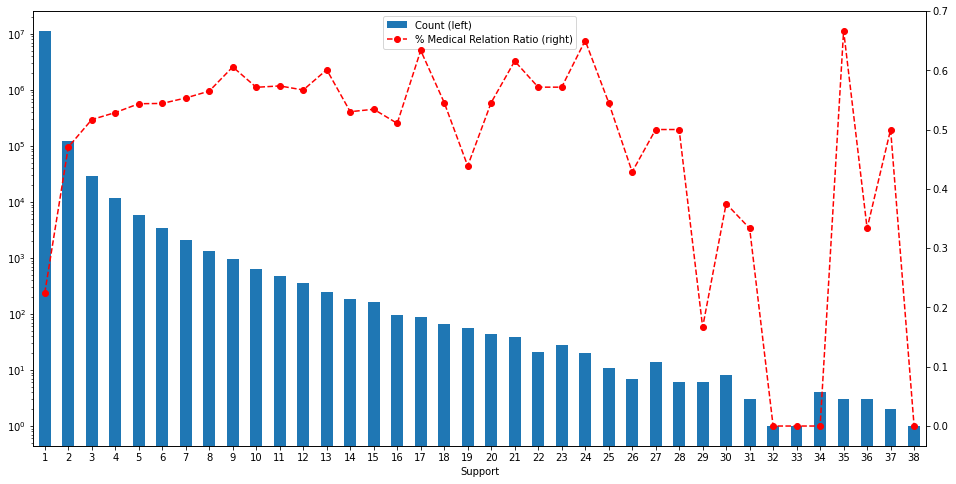

In [44]:
support_data = pd.Series(medical).groupby(health_causenet.support).agg(["mean", "size"])
support_data["mean_x"] = support_data.index.values - 1
ax_0 = support_data["size"].plot.bar(figsize=(16,8), fontsize=10, logy=True, xlabel="Support", label="Counts")
support_data.plot.line(x="mean_x", y="mean", secondary_y=True, xlabel="Support", label="% medical", color="red", marker="o", linestyle="dashed", ax=ax_0)

handles, _ = ax_0.get_legend_handles_labels()
handles.extend(ax_0.right_ax.get_lines())
ax_0.legend(handles, ["Count (left)", "% Medical Relation Ratio (right)"], loc=9)

fig = ax_0.get_figure()
fig.savefig("figures/causenet-support-medical-relation-ratio-discriminative-weight.pdf", bbox_inches="tight")

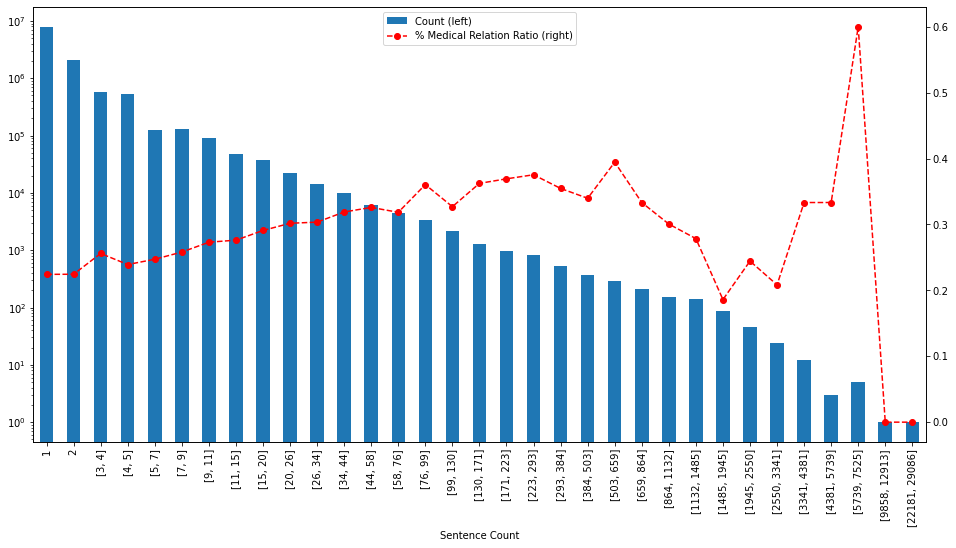

In [45]:
bins = pd.cut(np.log(health_causenet["count"]), bins=38)
bins = bins.map(lambda x: pd.Interval(np.exp(x.left), np.exp(x.right), closed=x.closed))
bins.name = "bins"
bins = bins.to_frame()
bins["string"] = bins.bins.map(lambda x: f"[{round(x.left)}, {round(x.right)}]" if round(x.left) != round(x.right) else str(round(x.left)))
count_data = medical.groupby(bins.string).agg(["mean", "size"]).dropna()
order = bins.drop_duplicates().sort_values("bins").string.values
count_data = count_data.loc[order]
ax_0 = count_data["size"].plot.bar(figsize=(16,8), fontsize=10, logy=True, xlabel="Log Sentence Count", label="Counts")
count_data.plot.line(y="mean", secondary_y=True, xlabel="Sentence Count", label="% medical", color="red", marker="o", linestyle="dashed", ax=ax_0)

handles, _ = ax_0.get_legend_handles_labels()
handles.extend(ax_0.right_ax.get_lines())
ax_0.legend(handles, ["Count (left)", "% Medical Relation Ratio (right)"], loc=9)
ax_0.set_xticklabels(labels=ax_0.get_xticklabels(), rotation=90)

fig = ax_0.get_figure()
fig.savefig("figures/causenet-count-medical-relation-ratio-discriminative-weight.pdf", bbox_inches="tight")

# PubMed CauseNet Pilot Study

In [54]:
term = "cold"
causenet.loc[causenet.cause.str.contains(term) | causenet.effect.str.contains(term)].sort_values("support", ascending=False).head(20)

,cause,effect,support,count
1740,herpes simplex virus,cold sores,11,476
1896,virus,cold,11,41
2285,virus,common cold,10,181
2859,viruses,common cold,9,122
2904,hsv-1,cold sores,9,74
2914,virus,cold sores,9,656
2943,viruses,colds,9,247
2999,cold weather,problems,9,30
4205,bacteria,colds,8,35
4393,herpes virus,cold sores,8,101


In [7]:
searcher = pyserini.search.SimpleSearcher(constants.PUBMED_INDEX_DIR)

In [52]:
hits = searcher.search("hair loss medical condition")

In [53]:
for hit in hits:
    clear_output()
    doc = json.loads(hit.raw)
    print(doc["pm_id"], "\n", doc["abstract"])
    inp = input()
    if inp == "c":
        break

17457763 
 Over the past several years there has been great interest in the potential role of laser/light-based treatments for male and female pattern hair loss. Despite aggressive marketing and centers claiming great success in the treatment of hair loss there is little scientific data supporting laser/light sources in hair loss. This paper is a consensus of hair loss experts on the current scientific data, mechanisms of action, safety, protocols and recommendations regarding laser/light treatment for hair loss. The authors believe that, while seemingly safe, there are no controlled, peer-reviewed studies validating current devices for hair loss and that all patients should be medically evaluated for any hair loss by a physician specialist to rule out other underlying medical conditions or the etiology of hair loss.
